# Introduction to the Low-salt-rejection Reverse Osmosis (LSRRO) Flowsheet
This tutorial shows how to build, initialize, simulate, and optimize an LSRRO flowsheet using WaterTAP.

![alt text](../docs/_static/flowsheets/lsrro.png)

## High-level Preview: Run an LSRRO optimization case. We will specify the following:
* 3-stage system (number_of_stages=3)
* System Water Recovery of 50% (water_recovery=0.50)
* 70 g/L TDS feed (Cin=70) 
* Feed flow rate of 0.001 m3/s (Qin=1e-3)


In [1]:
from watertap.flowsheets.lsrro.lsrro import (
    ACase,
    BCase,
    ABTradeoff,
    run_lsrro_case,
)
import logging
logging.getLogger("idaes").setLevel(logging.ERROR)
logging.getLogger("pyomo").setLevel(logging.ERROR)

In [3]:
m, results = run_lsrro_case(
    number_of_stages=3, # total number of stages
    water_recovery=0.50, # overall water recovery
    Cin=70,  # inlet NaCl conc in kg/m3,
    Qin=1e-3,  # inlet feed flowrate in m3/s
    quick_start=True   # skip rigorous initialization procedure for quick results (increased risk of non-convergence)
)


Feed Concentration = 70.0 ppt

***---Simulation results---***
Simulation failed. The current configuration is infeasible. Please adjust the decision variables.

***---Optimization results---***
----system metrics----
Feed: 1.05 kg/s, 66946 ppm
Product: 0.498 kg/s, 1511 ppm
Brine: 0.548 kg/s, 126470 ppm
Volumetric water recovery: 50.0%
Number of Stages: 3
Total Membrane Area: 319.44
Energy Consumption: 6.3 kWh/m3
Levelized cost of water: 1.54 $/m3
Primary Pump Capital Cost ($/m3):0.4685558390042717
Booster Pump Capital Cost ($/m3): 0.08453309297688603
ERD Capital Cost ($/m3):0.03715961312932659
Membrane Capital Cost ($/m3): 0.16044632535512127
Indirect Capital Cost ($/m3): 0.37534743523280284
Electricity cost ($/m3): 0.44270830493003077


--decision variables--
Stage 1 operating pressure 85.0 bar
Stage 1 membrane area      229.0 m2
Stage 1 water perm. coeff.  1.5 LMH/bar
Stage 1 salt perm. coeff.  0.1 LMH
Stage 2 operating pressure 65.0 bar
Stage 2 membrane area      89.5 m2
Stage 2 wat

## Overview of setting up and optimizing the LSRRO flowsheet--step by step.
* Step 0: Import Python libraries.

* Step 1: Build the LSRRO flowsheet.

* Step 2: Set specifications for LSRRO flowsheet.

* Step 3: Initialize the LSRRO flowsheet.

* Step 4: Optimize the LSRRO flowsheet.

* Step 5: Visualize results.

## Step 0: Import libraries.

In [4]:
# Import LSRRO flowsheet module
from watertap.flowsheets.lsrro import lsrro

## Step 1: Build the LSRRO flowsheet.

In [5]:
# Create a Pyomo concrete model, flowsheet, and NaCl property parameter block.
m = lsrro.build(
    number_of_stages=3,
    has_NaCl_solubility_limit=True,
    has_calculated_concentration_polarization=True,
    has_calculated_ro_pressure_drop=True,
    number_of_RO_finite_elements=10,

)


## Step 2: Set specifications for the LSRRO flowsheet.

In [6]:
lsrro.set_operating_conditions(m)

Feed Concentration = 70.0 ppt


## Step 3: Initialize the LSRRO flowsheet model.

In [7]:
lsrro.initialize(m)

--------------------START FORWARD INITIALIZATION PASS--------------------
--------------------START BACKWARD INITIALIZATION PASS--------------------
--------------------START FORWARD INITIALIZATION PASS--------------------
INFO: Starting Sequential Decomposition
INFO: Starting first pass run of network
2025-09-17 13:54:03 [INFO] idaes.init.fs.feed: Initialization Complete.
2025-09-17 13:54:04 [INFO] idaes.init.fs.PrimaryPumps[1].control_volume: Initialization Complete
2025-09-17 13:54:04 [INFO] idaes.init.fs.PrimaryPumps[1]: Initialization Complete: optimal - Optimal Solution Found
2025-09-17 13:54:05 [INFO] idaes.init.fs.Mixers[1]: Initialization Complete: optimal - Optimal Solution Found
2025-09-17 13:54:05 [INFO] idaes.init.fs.ROUnits[1].feed_side: Initialization Complete
2025-09-17 13:54:08 [INFO] idaes.init.fs.ROUnits[1]: Initialization Complete: optimal - Optimal Solution Found
2025-09-17 13:54:08 [INFO] idaes.init.fs.EnergyRecoveryDevices[1].control_volume: Initialization Comple

## Step 4: Simulate the LSRRO flowsheet.

In [8]:
lsrro.solve(m, tee=False, raise_on_failure=True)

print("Simulation Results:\n")
lsrro.display_system(m)

Simulation Results:

----system metrics----
Feed: 1.05 kg/s, 66946 ppm
Product: 0.349 kg/s, 751 ppm
Brine: 0.697 kg/s, 100084 ppm
Volumetric water recovery: 35.0%
Number of Stages: 3
Total Membrane Area: 183.33
Energy Consumption: 10.4 kWh/m3
Levelized cost of water: 2.41 $/m3
Primary Pump Capital Cost ($/m3):0.8290266209380903
Booster Pump Capital Cost ($/m3): 0.16734617929012008
ERD Capital Cost ($/m3):0.06539992139610248
Membrane Capital Cost ($/m3): 0.14403584004108508
Indirect Capital Cost ($/m3): 0.6029042808326991
Electricity cost ($/m3): 0.7309236776200411




In [9]:
# store LCOW breakdown values from simulation results
from pyomo.environ import value, Expression
def get_lcow_breakdown(m, new_case=None, existing_case_list=None,results=None):
    if not isinstance(new_case, str):
        raise ValueError("case must be a string")
    if results is None:
        lcow_breakdown =  {"Membrane CAPEX": [value(m.fs.costing.LCOW_aggregate_direct_capex["ReverseOsmosis1D"])],
            "Pump CAPEX": [value(m.fs.costing.LCOW_aggregate_direct_capex["Pump"])],
            "ERD CAPEX": [value(m.fs.costing.LCOW_aggregate_direct_capex["EnergyRecoveryDevice"])],
            "Indirect CAPEX": [value(sum(i for i in m.fs.costing.LCOW_aggregate_indirect_capex.values()))],
            "Membrane OPEX": [value(m.fs.costing.LCOW_aggregate_fixed_opex["ReverseOsmosis1D"])],
            "Electricity": [value(m.fs.costing.LCOW_aggregate_variable_opex["electricity"])],
            "Other OPEX": [value(sum(i for i in m.fs.costing.LCOW_aggregate_fixed_opex.values())-m.fs.costing.LCOW_aggregate_fixed_opex["ReverseOsmosis1D"])],}
        
        check = 0
        for i in lcow_breakdown.values():
            check += i[0]
        if check < 0.99*value(m.fs.costing.LCOW) or check > 1.01*value(m.fs.costing.LCOW):
            raise ValueError("LCOW breakdown does not sum to total LCOW")
        
        if existing_case_list is None:
            caselist= [new_case]
        else:
            raise ValueError("existing_case_list must be None if results is None")
        
        return lcow_breakdown, caselist
    
    else:
        if not hasattr(m.fs.costing,"LCOW_total_indirect_capex"):
            m.fs.costing.LCOW_total_indirect_capex = Expression(expr=sum(i for i in m.fs.costing.LCOW_aggregate_indirect_capex.values()))
        if not hasattr(m.fs.costing,"LCOW_total_fixed_opex"):
            m.fs.costing.LCOW_total_fixed_opex = Expression(expr=sum(i for i in m.fs.costing.LCOW_aggregate_fixed_opex.values())-m.fs.costing.LCOW_aggregate_fixed_opex["ReverseOsmosis1D"])
        
        lcow_breakdown_dict =  {"Membrane CAPEX": m.fs.costing.LCOW_aggregate_direct_capex["ReverseOsmosis1D"],
        "Pump CAPEX": m.fs.costing.LCOW_aggregate_direct_capex["Pump"],
        "ERD CAPEX": m.fs.costing.LCOW_aggregate_direct_capex["EnergyRecoveryDevice"],
        "Indirect CAPEX": m.fs.costing.LCOW_total_indirect_capex,
        "Membrane OPEX": m.fs.costing.LCOW_aggregate_fixed_opex["ReverseOsmosis1D"],
        "Electricity": m.fs.costing.LCOW_aggregate_variable_opex["electricity"],
        "Other OPEX": m.fs.costing.LCOW_total_fixed_opex}
        
        for k,v in lcow_breakdown_dict.items():
            results[k].append(value(v))
        
        check = 0
        for i in lcow_breakdown_dict.values():
            check += value(i)
        if check < 0.99*value(m.fs.costing.LCOW) or check > 1.01*value(m.fs.costing.LCOW):
            raise ValueError(f"LCOW breakdown does not sum to total LCOW. LCOW={value(m.fs.costing.LCOW)} vs summed LCOW = {check}")

        
        existing_case_list.append(new_case)
        return results, existing_case_list

In [10]:
lcow_breakdown_results, case_list = get_lcow_breakdown(m, new_case="Simulated Results")


In [11]:
lcow_breakdown_results

{'Membrane CAPEX': [0.07201792002054254],
 'Pump CAPEX': [0.49818640011410525],
 'ERD CAPEX': [0.032699960698051235],
 'Indirect CAPEX': [0.6029042808326991],
 'Membrane OPEX': [0.1512376320431393],
 'Electricity': [0.7309236776200411],
 'Other OPEX': [0.3185318164872939]}

## Step 5: Optimize the LSRRO flowsheet.

In [12]:
lsrro.optimize_set_up(m,
    water_recovery=0.5,
    A_case=ACase.optimize, # water permeability coefficient
    B_case=BCase.optimize, # salt permeability coefficient
    AB_tradeoff=ABTradeoff.equality_constraint, # water and salt permeability equality constraints
    permeate_quality_limit=1000e-6,
    )
optimization_results = lsrro.solve(m, raise_on_failure=True) 

In [13]:
print("Optimization Results:\n")
lsrro.display_system(m)

Optimization Results:

----system metrics----
Feed: 1.05 kg/s, 66946 ppm
Product: 0.498 kg/s, 1000 ppm
Brine: 0.548 kg/s, 126890 ppm
Volumetric water recovery: 50.0%
Number of Stages: 3
Total Membrane Area: 265.86
Energy Consumption: 7.6 kWh/m3
Levelized cost of water: 1.71 $/m3
Primary Pump Capital Cost ($/m3):0.5047265838517887
Booster Pump Capital Cost ($/m3): 0.1318504520423674
ERD Capital Cost ($/m3):0.04116999386381932
Membrane Capital Cost ($/m3): 0.14321735175018754
Indirect Capital Cost ($/m3): 0.41048219075408143
Electricity cost ($/m3): 0.5323462487411291




In [14]:
lcow_breakdown_results

{'Membrane CAPEX': [0.07201792002054254],
 'Pump CAPEX': [0.49818640011410525],
 'ERD CAPEX': [0.032699960698051235],
 'Indirect CAPEX': [0.6029042808326991],
 'Membrane OPEX': [0.1512376320431393],
 'Electricity': [0.7309236776200411],
 'Other OPEX': [0.3185318164872939]}

In [15]:
lcow_breakdown_results, case_list = get_lcow_breakdown(m, new_case="Optimization Results", existing_case_list=case_list, results=lcow_breakdown_results)


In [16]:
lcow_breakdown_results


{'Membrane CAPEX': [0.07201792002054254, 0.07160867587509377],
 'Pump CAPEX': [0.49818640011410525, 0.3182885179470781],
 'ERD CAPEX': [0.032699960698051235, 0.02058499693190966],
 'Indirect CAPEX': [0.6029042808326991, 0.41048219075408154],
 'Membrane OPEX': [0.1512376320431393, 0.1503782193376969],
 'Electricity': [0.7309236776200411, 0.5323462487411291],
 'Other OPEX': [0.3185318164872939, 0.20332410892739267]}

## Step 6: Visualize results

### Compare the breakdown of levelized cost of water for simulated and optimized results.


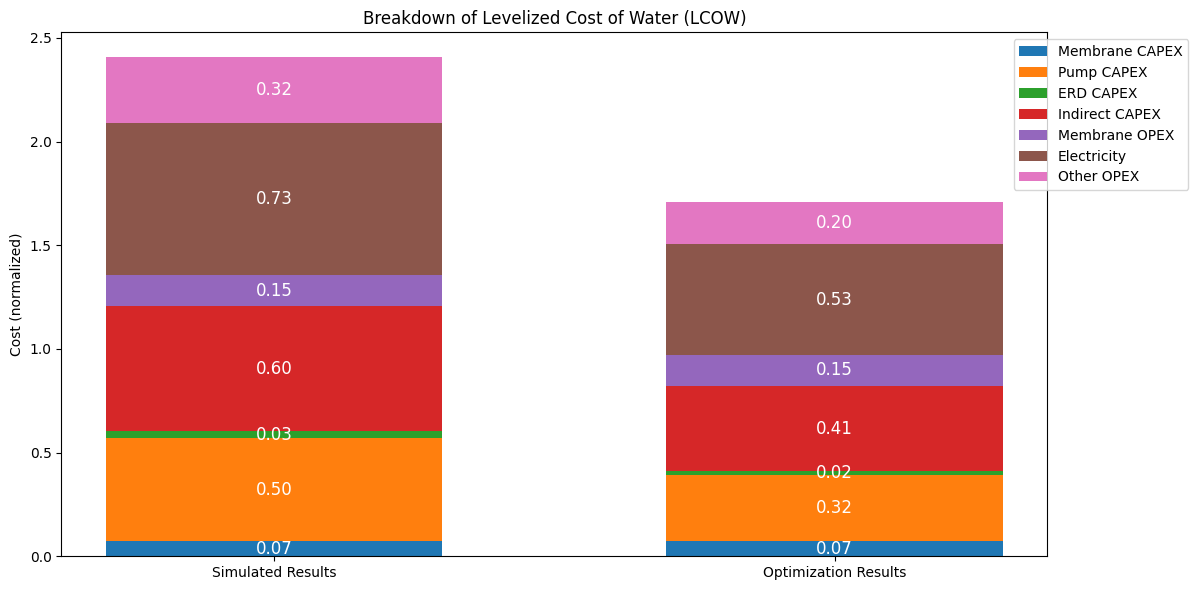

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lcow_breakdown(data_dict, scenario_labels=None):
    """
    Plots a stacked bar chart from a dictionary of LCOW components.
    
    Parameters:
    - data_dict: dict where keys are cost categories and values are lists of values per scenario.
    """
    categories = list(data_dict.keys())
    num_scenarios = len(next(iter(data_dict.values())))
    if scenario_labels is None:
        scenario_labels = [f"Scenario {i+1}" for i in range(num_scenarios)]
    
    # Prepare data
    values = np.array([data_dict[cat] for cat in categories])  # shape: (num_categories, num_scenarios)
    
    # Plot setup
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.6
    x = np.arange(num_scenarios)
    bottoms = np.zeros(num_scenarios)

    # Plot each category
    for i, cat in enumerate(categories):
        bar = ax.bar(x, values[i], bar_width, bottom=bottoms, label=cat)
        
        # Add value labels
        for j in range(num_scenarios):
            ax.text(x[j], bottoms[j] + values[i][j]/2, f'{values[i][j]:.2f}',
                    ha='center', va='center', fontsize=12, color='white')
        
        bottoms += values[i]

    # Final touches
    ax.set_xticks(x)
    ax.set_xticklabels(scenario_labels)
    ax.set_ylabel('Cost (normalized)')
    ax.set_title('Breakdown of Levelized Cost of Water (LCOW)')
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.tight_layout()
    plt.show()
plot_lcow_breakdown(lcow_breakdown_results, scenario_labels=case_list)

## 

### Conduct sensitivity analysis on feed concentration and water recovery rate and visualize optimal levelized cost of water.

In [27]:
from watertap.flowsheets.lsrro.multi_sweep import _lsrro_presweep as setup_sensitivity_sweep
from parameter_sweep import LinearSample, parameter_sweep
import pandas as pd
from pyomo.environ import units as pyunits, Expression  


def feed_concentration_recovery_profile(m,number_of_stages, points_per_sweep=5, quick_start=True):
    """
    Generate a cost-optimal feed concentration vs recovery profile for a given number of stages.
    Args:

        points_per_sweep (int): Number of points to sample in the sweep.
        number_of_stages (int): Number of RO stages in the system.
    Returns:
        results (pd.DataFrame): DataFrame containing the sweep results.
        output_filename (str): Path to the CSV file where results are saved.
        fig, ax: Matplotlib figure and axis objects for the contour plot.
    """
    output_filename = f"param_sweep_output/{number_of_stages}_stage/results_LSRRO.csv"
    sweep_params = {}
    outputs = {}
    nx = points_per_sweep
    if m is None:
        m = setup_sensitivity_sweep(number_of_stages=number_of_stages, quick_start=quick_start)
    else:
        if (m.fs.NumberOfStages == number_of_stages) or (m.fs.NumberOfStages is None):
            pass
        else:
            raise ValueError("Model already exists with a different number of stages. Please pass None as the model argument to create a new model, or pass None as the number_of_stages argument.")
    m.fs.feed.flow_mass_phase_comp.unfix()
    m.fs.feed.properties[0].conc_mass_phase_comp["Liq", "NaCl"].fix()
    m.fs.feed.properties[0].flow_vol_phase["Liq"].fix()
    # Sweep parameters ------------------------------------------------------------------------

    sweep_params["Feed Concentration"] = LinearSample(m.fs.feed.properties[0].conc_mass_phase_comp["Liq", "NaCl"], 70, 150, nx)

    sweep_params["Volumetric Recovery Rate"] = LinearSample(m.fs.water_recovery, 0.2, 0.5, nx)

    # Outputs  -------------------------------------------------------------------------------
    outputs["LCOW"] = m.fs.costing.LCOW
    outputs["LCOW wrt Feed Flow"] = m.fs.costing.LCOW_feed
    outputs["SEC"] = m.fs.costing.specific_energy_consumption
    outputs["SEC wrt Feed"] = m.fs.costing.specific_energy_consumption_feed
    outputs["Number of Stages"] = m.fs.NumberOfStages
    outputs["Final Brine Concentration"] = m.fs.disposal.properties[
        0
    ].conc_mass_phase_comp["Liq", "NaCl"]
    outputs["Final Permeate Concentration (ppm)"] = (
        m.fs.product.properties[0].mass_frac_phase_comp["Liq", "NaCl"] * 1e6
    )
    outputs["Annual Feed Flow"] = m.fs.annual_feed
    outputs["Annual Water Production"] = m.fs.costing.annual_water_production


    outputs["Pump Work In (kW)"] = m.fs.total_pump_work
    outputs["Pump Work Recovered (kW)"] = m.fs.recovered_pump_work
    outputs["Net Pump Work In (kW)"] = m.fs.net_pump_work
    outputs["Energy Recovery (%)"] = (
        -m.fs.recovered_pump_work / m.fs.total_pump_work * 100
    )

    outputs["Mass Water Recovery Rate (%)"] = m.fs.mass_water_recovery * 100
    outputs["System Salt Rejection (%)"] = m.fs.system_salt_rejection * 100

    outputs["Total Membrane Area"] = m.fs.total_membrane_area
    
    
    outputs["Total Capex LCOW"] = (
        m.fs.costing.total_capital_cost
        * m.fs.costing.capital_recovery_factor
        / m.fs.costing.annual_water_production
    )
    outputs["Total Opex LCOW"] = (
        m.fs.costing.total_operating_cost / m.fs.costing.annual_water_production
    )

    outputs["Primary Pump Capex LCOW"] = m.fs.costing.primary_pump_capex_lcow
    outputs["Booster Pump Capex LCOW"] = m.fs.costing.booster_pump_capex_lcow

    outputs["ERD Capex LCOW"] = m.fs.costing.erd_capex_lcow
    outputs["Membrane Capex LCOW"] = m.fs.costing.membrane_capex_lcow
    outputs["Indirect Capex LCOW"] = m.fs.costing.indirect_capex_lcow
    outputs["Electricity LCOW"] = m.fs.costing.electricity_lcow
    outputs["Membrane Replacement LCOW"] = m.fs.costing.membrane_replacement_lcow
    outputs["Chem-labor-maintenance LCOW"] = (
        m.fs.costing.chemical_labor_maintenance_lcow
    )

    outputs["Pumping Energy Agg LCOW"] = m.fs.costing.pumping_energy_aggregate_lcow
    outputs["Membrane Agg LCOW"] = m.fs.costing.membrane_aggregate_lcow

    outputs.update(
        {
            f"Feed Pressure (psi)-Stage {idx}": pyunits.convert(
                pump.control_volume.properties_out[0].pressure, to_units=pyunits.psi
            )
            for idx, pump in m.fs.PrimaryPumps.items()
        }
    )

    outputs.update(
        {
            f"Pump Feed Flowrate-Stage {idx} (gpm)": pyunits.convert(
                pump.control_volume.properties_out[0].flow_vol_phase['Liq'], to_units=pyunits.gal/pyunits.min
            )
            for idx, pump in m.fs.PrimaryPumps.items()
        }
    )

    outputs.update(
        {
            f"Permeate flowrate-Stage {idx} (gpm)": pyunits.convert(
                stage.mixed_permeate[0].flow_vol_phase["Liq"], to_units=pyunits.gal/pyunits.min
            )
                    for idx, stage in m.fs.ROUnits.items()
               
        }
    )

    outputs.update(
        {
            f"Membrane Area-Stage {idx}": stage.area
            for idx, stage in m.fs.ROUnits.items()
        }
    )

    outputs.update(
        {
            f"Total Membrane Length-Stage {idx}": stage.length
            for idx, stage in m.fs.ROUnits.items()
        }
    )

    outputs.update(
        {
            f"Effective Membrane Width-Stage {idx}": stage.width
            for idx, stage in m.fs.ROUnits.items()
        }
    )

    outputs.update(
        {
            f"Observed Rejection (%)-Stage {idx}": stage.rejection_phase_comp[
                0, "Liq", "NaCl"
            ]
            * 100
            for idx, stage in m.fs.ROUnits.items()
        }
    )

    outputs.update(
        {
            f"Observed Salt Passage (%)-Stage {idx}": (
                1 - stage.rejection_phase_comp[0, "Liq", "NaCl"]
            )
            * 100
            for idx, stage in m.fs.ROUnits.items()
        }
    )

    outputs.update(
        {
            f"Mass Salt Passage (%)-Stage {idx}": (
                stage.mixed_permeate[0].flow_mass_phase_comp["Liq", "NaCl"]
                / stage.feed_side.properties[0, 0].flow_mass_phase_comp["Liq", "NaCl"]
            )
            * 100
            for idx, stage in m.fs.ROUnits.items()
        }
    )

    outputs.update(
        {
            f"Volumetric Module Recovery Rate (%)-Stage {idx}": stage.recovery_vol_phase[
                0, "Liq"
            ]
            * 100
            for idx, stage in m.fs.ROUnits.items()
        }
    )

    outputs.update(
        {
            f"Mass Water Module Recovery Rate (%)-Stage {idx}": stage.recovery_mass_phase_comp[
                0, "Liq", "H2O"
            ]
            * 100
            for idx, stage in m.fs.ROUnits.items()
        }
    )

    outputs.update(
        {
            f"Volumetric Stage Recovery Rate (%)-Stage {idx}": m.fs.stage_recovery_vol[
                idx
            ]
            * 100
            for idx in m.fs.Stages
        }
    )

    outputs.update(
        {
            f"Mass Water Stage Recovery Rate (%)-Stage {idx}": m.fs.stage_recovery_mass_H2O[
                idx
            ]
            * 100
            for idx in m.fs.Stages
        }
    )

    outputs.update(
        {
            f"A-Value (LMH/bar)-Stage {idx}": stage.A_comp[0, "H2O"] * 3.6e11
            for idx, stage in m.fs.ROUnits.items()
        }
    )

    outputs.update(
        {
            f"B-Value (LMH)-Stage {idx}": stage.B_comp[0, "NaCl"] * 3.6e6
            for idx, stage in m.fs.ROUnits.items()
        }
    )

    outputs.update(
        {
            f"Average Water Flux (LMH)-Stage {idx}": stage.flux_mass_phase_comp_avg[
                0, "Liq", "H2O"
            ]
            * 3.6e3
            for idx, stage in m.fs.ROUnits.items()
        }
    )

    outputs.update(
        {
            f"Average NaCl Flux (GMH)-Stage {idx}": stage.flux_mass_phase_comp_avg[
                0, "Liq", "NaCl"
            ]
            * 3.6e6
            for idx, stage in m.fs.ROUnits.items()
        }
    )

    outputs.update(
        {
            f"Pressure Drop (bar)-Stage {idx}": -pyunits.convert(
                stage.deltaP[0], to_units=pyunits.bar
            )
            for idx, stage in m.fs.ROUnits.items()
        }
    )
    outputs.update(
        {
            f"Inlet Reynolds Number-Stage {idx}": stage.feed_side.N_Re[0, 0]
            for idx, stage in m.fs.ROUnits.items()
        }
    )
    outputs.update(
        {
            f"Outlet Reynolds Number-Stage {idx}": stage.feed_side.N_Re[0, 1]
            for idx, stage in m.fs.ROUnits.items()
        }
    )
    outputs.update(
        {
            f"Inlet Crossflow Velocity-Stage {idx}": stage.feed_side.velocity[0, 0]
            for idx, stage in m.fs.ROUnits.items()
        }
    )
    outputs.update(
        {
            f"Outlet Crossflow Velocity-Stage {idx}": stage.feed_side.velocity[0, 1]
            for idx, stage in m.fs.ROUnits.items()
        }
    )

    outputs.update(
        {
            f"Primary Pump SEC-Stage {idx}": pyunits.convert(
                pump.work_mechanical[0], to_units=pyunits.kW
            )
            / pyunits.convert(
                m.fs.product.properties[0].flow_vol,
                to_units=pyunits.m**3 / pyunits.hr,
            )
            for idx, pump in m.fs.PrimaryPumps.items()
        }
    )

    m.fs.zero_expression = Expression(expr=0.0)

    outputs["Booster Pump SEC-Stage 1"] = m.fs.zero_expression
    outputs.update(
        {
            f"Booster Pump SEC-Stage {idx}": pyunits.convert(
                pump.work_mechanical[0], to_units=pyunits.kW
            )
            / pyunits.convert(
                m.fs.product.properties[0].flow_vol,
                to_units=pyunits.m**3 / pyunits.hr,
            )
            for idx, pump in m.fs.BoosterPumps.items()
        }
    )
    outputs.update(
        {
            f"ERD SEC-Stage 1": pyunits.convert(
                m.fs.EnergyRecoveryDevices[1].work_mechanical[0], to_units=pyunits.kW
            )
            / pyunits.convert(
                m.fs.product.properties[0].flow_vol,
                to_units=pyunits.m**3 / pyunits.hr,
            )
        }
    )
    outputs.update(
        {
            f"ERD SEC-Stage {idx}": m.fs.zero_expression
            for idx in m.fs.IntermediateStages
        }
    )
    if m.fs.FirstStage != m.fs.LastStage:
        outputs.update(
            {
                f"ERD SEC-Stage {m.fs.LastStage}": pyunits.convert(
                    m.fs.EnergyRecoveryDevices[m.fs.LastStage].work_mechanical[0],
                    to_units=pyunits.kW,
                )
                / pyunits.convert(
                    m.fs.product.properties[0].flow_vol,
                    to_units=pyunits.m**3 / pyunits.hr,
                )
            }
        )

    outputs.update(
        {
            f"Net SEC-Stage {idx}": outputs[f"Primary Pump SEC-Stage {idx}"]
            + outputs[f"Booster Pump SEC-Stage {idx}"]
            + outputs[f"ERD SEC-Stage {idx}"]
            for idx in m.fs.Stages
        }
    )

    sweep_sensitivity_results = parameter_sweep(
            m,
            sweep_params,
            outputs,
            csv_results_file_name=output_filename,
            optimize_function=lsrro.solve,
            interpolate_nan_outputs=True,
        )
    results= pd.read_csv(output_filename)

    fig, ax = plt.subplots(1,1, figsize=(8, 12), dpi=300)

    X, Y = np.meshgrid(np.unique(results["# Feed Concentration"].to_numpy()), np.unique(results["Volumetric Recovery Rate"].to_numpy()))

    Z = results["LCOW"].to_numpy().reshape(X.shape)

    cbar = ax.contourf(X,Y,Z,cmap="jet")

    ax.set_xlabel("Feed Concentration (kg/m3)")
    ax.set_ylabel("Volumetric Recovery Rate (--)")

    cbar = fig.colorbar(cbar, ax=ax)
    cbar.set_label("LCOW ($/m3)")
    ax.set_title(f"{number_of_stages}-Stage System");
    contours = ax.contour(X,Y,Z, colors="k")

    ax.clabel(contours)


    return results, output_filename, fig, ax


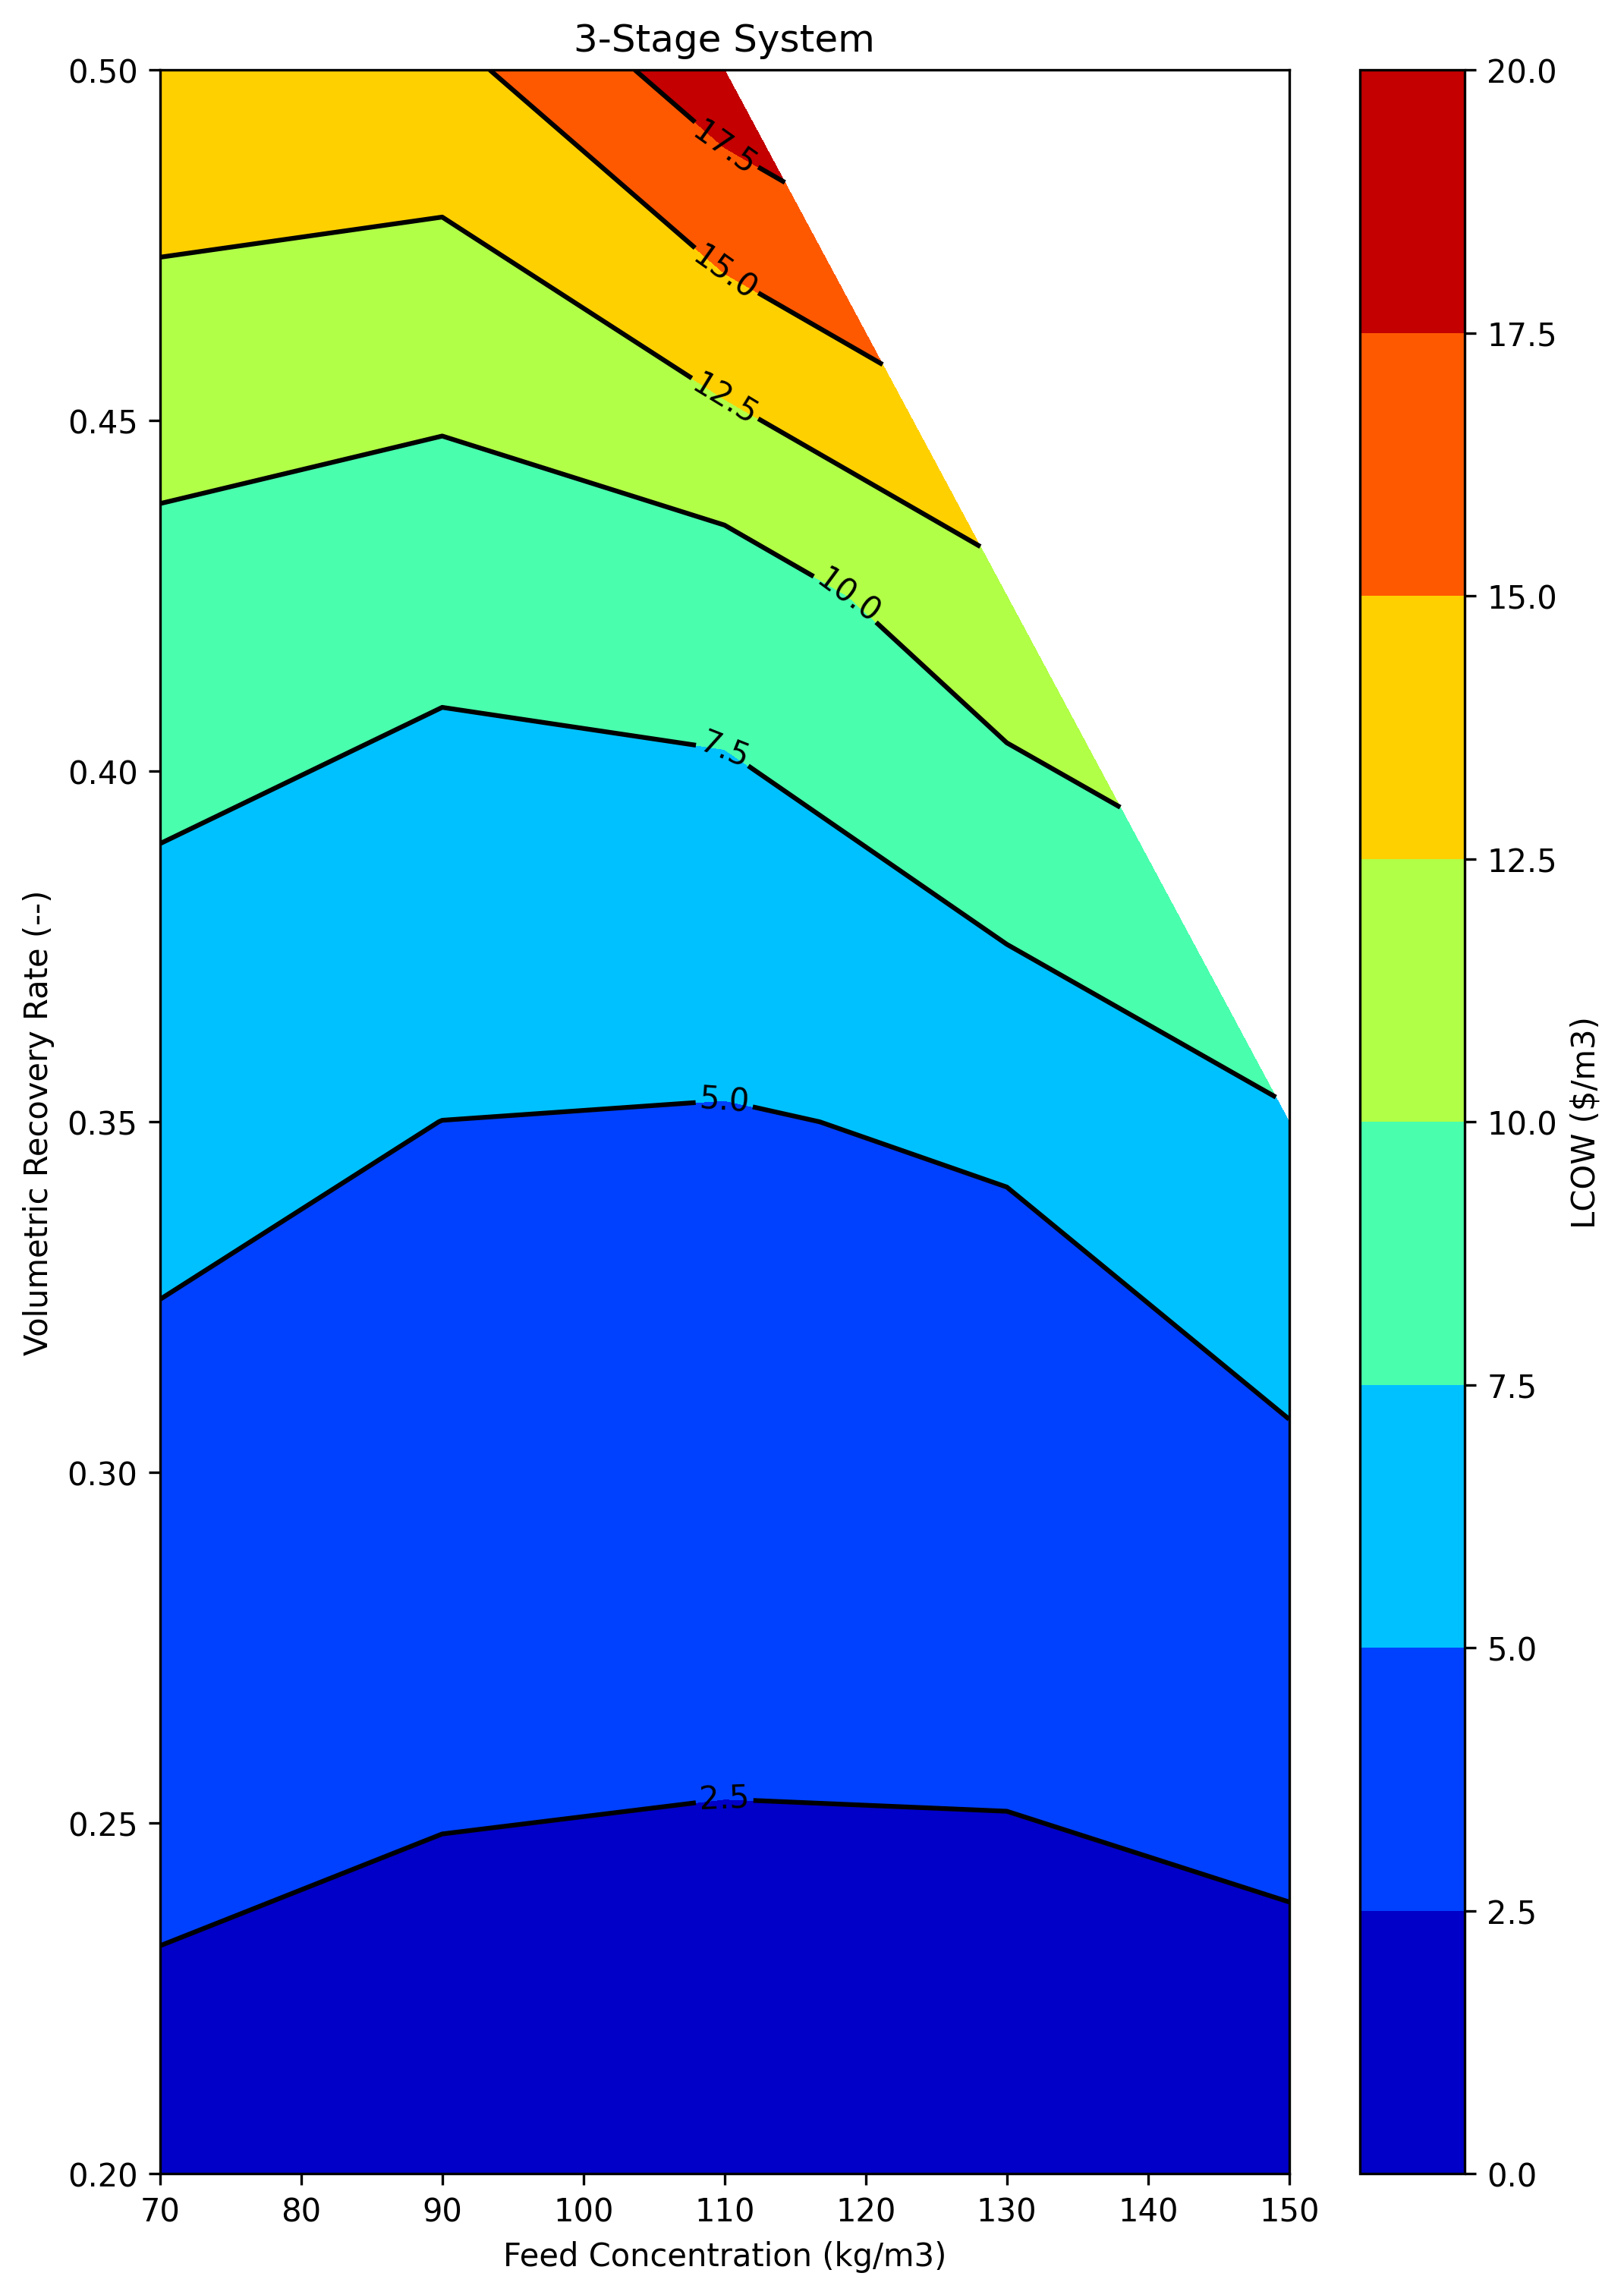

In [28]:
results3, _, fig3, ax3 = feed_concentration_recovery_profile(m=m,number_of_stages=3, points_per_sweep=5)

In [ ]:
# Show all rows and columns for 3-stage sweep results
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

results3

,# Feed Concentration,Volumetric Recovery Rate,LCOW,LCOW wrt Feed Flow,SEC,SEC wrt Feed,Number of Stages,Final Brine Concentration,Final Permeate Concentration (ppm),Annual Feed Flow,Annual Water Production,Pump Work In (kW),Pump Work Recovered (kW),Net Pump Work In (kW),Energy Recovery (%),Mass Water Recovery Rate (%),System Salt Rejection (%),Total Membrane Area,Total Capex LCOW,Total Opex LCOW,Primary Pump Capex LCOW,Booster Pump Capex LCOW,ERD Capex LCOW,Membrane Capex LCOW,Indirect Capex LCOW,Electricity LCOW,Membrane Replacement LCOW,Chem-labor-maintenance LCOW,Pumping Energy Agg LCOW,Membrane Agg LCOW,Feed Pressure (psi)-Stage 1,Feed Pressure (psi)-Stage 2,Feed Pressure (psi)-Stage 3,Pump Feed Flowrate-Stage 1 (gpm),Pump Feed Flowrate-Stage 2 (gpm),Pump Feed Flowrate-Stage 3 (gpm),Permeate flowrate-Stage 1 (gpm),Permeate flowrate-Stage 2 (gpm),Permeate flowrate-Stage 3 (gpm),Membrane Area-Stage 1,Membrane Area-Stage 2,Membrane Area-Stage 3,Total Membrane Length-Stage 1,Total Membrane Length-Stage 2,Total Membrane Length-Stage 3,Effective Membrane Width-Stage 1,Effective Membrane Width-Stage 2,Effective Membrane Width-Stage 3,Observed Rejection (%)-Stage 1,Observed Rejection (%)-Stage 2,Observed Rejection (%)-Stage 3,Observed Salt Passage (%)-Stage 1,Observed Salt Passage (%)-Stage 2,Observed Salt Passage (%)-Stage 3,Mass Salt Passage (%)-Stage 1,Mass Salt Passage (%)-Stage 2,Mass Salt Passage (%)-Stage 3,Volumetric Module Recovery Rate (%)-Stage 1,Volumetric Module Recovery Rate (%)-Stage 2,Volumetric Module Recovery Rate (%)-Stage 3,Mass Water Module Recovery Rate (%)-Stage 1,Mass Water Module Recovery Rate (%)-Stage 2,Mass Water Module Recovery Rate (%)-Stage 3,Volumetric Stage Recovery Rate (%)-Stage 1,Volumetric Stage Recovery Rate (%)-Stage 2,Volumetric Stage Recovery Rate (%)-Stage 3,Mass Water Stage Recovery Rate (%)-Stage 1,Mass Water Stage Recovery Rate (%)-Stage 2,Mass Water Stage Recovery Rate (%)-Stage 3,A-Value (LMH/bar)-Stage 1,A-Value (LMH/bar)-Stage 2,A-Value (LMH/bar)-Stage 3,B-Value (LMH)-Stage 1,B-Value (LMH)-Stage 2,B-Value (LMH)-Stage 3,Average Water Flux (LMH)-Stage 1,Average Water Flux (LMH)-Stage 2,Average Water Flux (LMH)-Stage 3,Average NaCl Flux (GMH)-Stage 1,Average NaCl Flux (GMH)-Stage 2,Average NaCl Flux (GMH)-Stage 3,Pressure Drop (bar)-Stage 1,Pressure Drop (bar)-Stage 2,Pressure Drop (bar)-Stage 3,Inlet Reynolds Number-Stage 1,Inlet Reynolds Number-Stage 2,Inlet Reynolds Number-Stage 3,Outlet Reynolds Number-Stage 1,Outlet Reynolds Number-Stage 2,Outlet Reynolds Number-Stage 3,Inlet Crossflow Velocity-Stage 1,Inlet Crossflow Velocity-Stage 2,Inlet Crossflow Velocity-Stage 3,Outlet Crossflow Velocity-Stage 1,Outlet Crossflow Velocity-Stage 2,Outlet Crossflow Velocity-Stage 3,Primary Pump SEC-Stage 1,Primary Pump SEC-Stage 2,Primary Pump SEC-Stage 3,Booster Pump SEC-Stage 1,Booster Pump SEC-Stage 2,Booster Pump SEC-Stage 3,ERD SEC-Stage 1,ERD SEC-Stage 2,ERD SEC-Stage 3,Net SEC-Stage 1,Net SEC-Stage 2,Net SEC-Stage 3
0,70.0,0.200,1.705656,0.341131,7.719651,1.543930,3.0,87.19052,1000.0,28401.84,5680.368,10.57771,-5.019558,5.558149,47.45412,20.39255,98.57749,76.46976,0.845595,0.860062,0.321780,0.002449,0.054564,0.044005,0.422797,0.540376,0.066007,0.253678,1.525236,0.180420,1154.863,145.0379,145.0377,15.85032,12.81813,12.816840,3.170065,0.129069,0.127782,66.19227,5.160927,5.116561,7.053889,0.230969,0.231313,9.383798,22.344690,22.119660,98.57878,10.49413,10.48205,1.421217,89.50587,89.51795,0.281948,0.892364,0.892484,19.838460,0.996989,0.996989,20.228250,1.000000,1.000000,20.0,1.006928,0.996989,20.39255,1.009999,1.000000,1.512,15.12000,15.12000,0.126,46.07713,46.07713,10.82041,5.52758,5.519756,10.83124,442.3476,442.2612,0.923871,0.010465,0.010483,124.9259,41.75257,41.75292,98.43082,41.33243,41.33279,0.126393,0.043003,0.043008,0.101389,0.042575,0.042579,14.557730,8.949655e-08,1.565807e-03,0.0,0.118544,0.013417,-6.173164,0.0,-0.798444,8.384569,0.118544,-0.783462
1,70.0,0.275,1.589335,0.437067,7.

Feed Concentration = 70.0 ppt


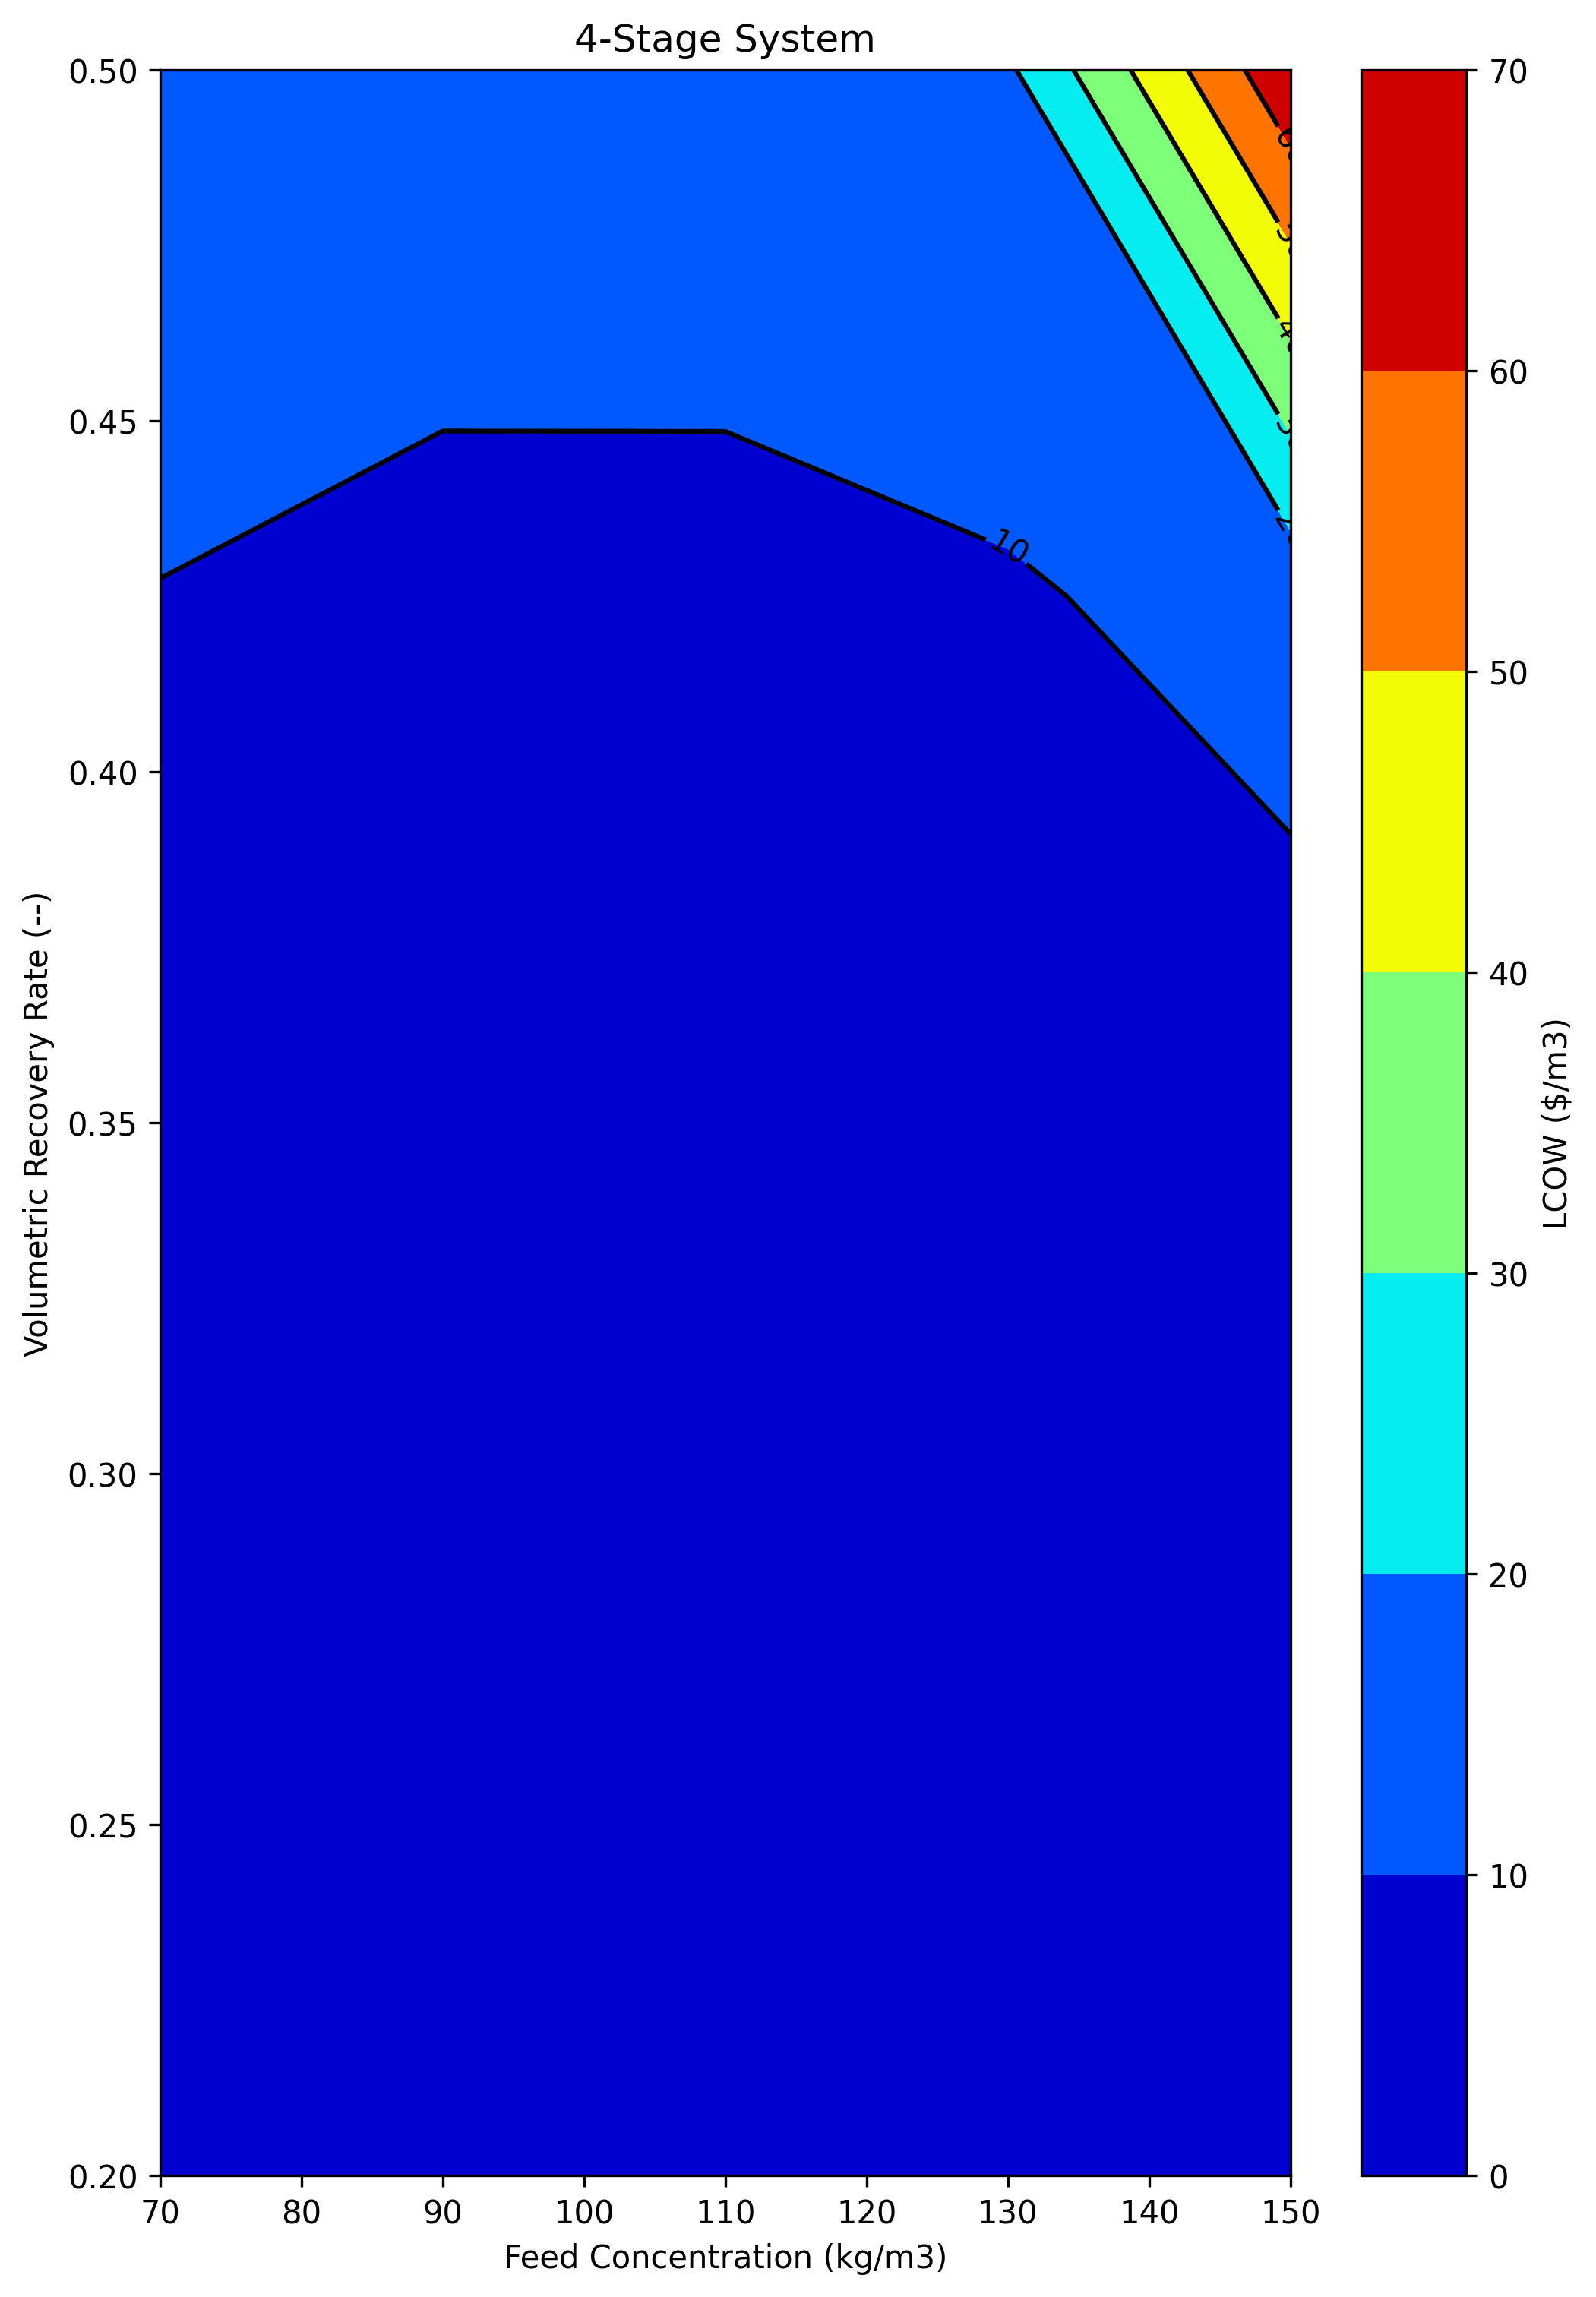

In [30]:
results4, _, fig4, ax4 = feed_concentration_recovery_profile(m=None,number_of_stages=4, points_per_sweep=5)

Feed Concentration = 70.0 ppt


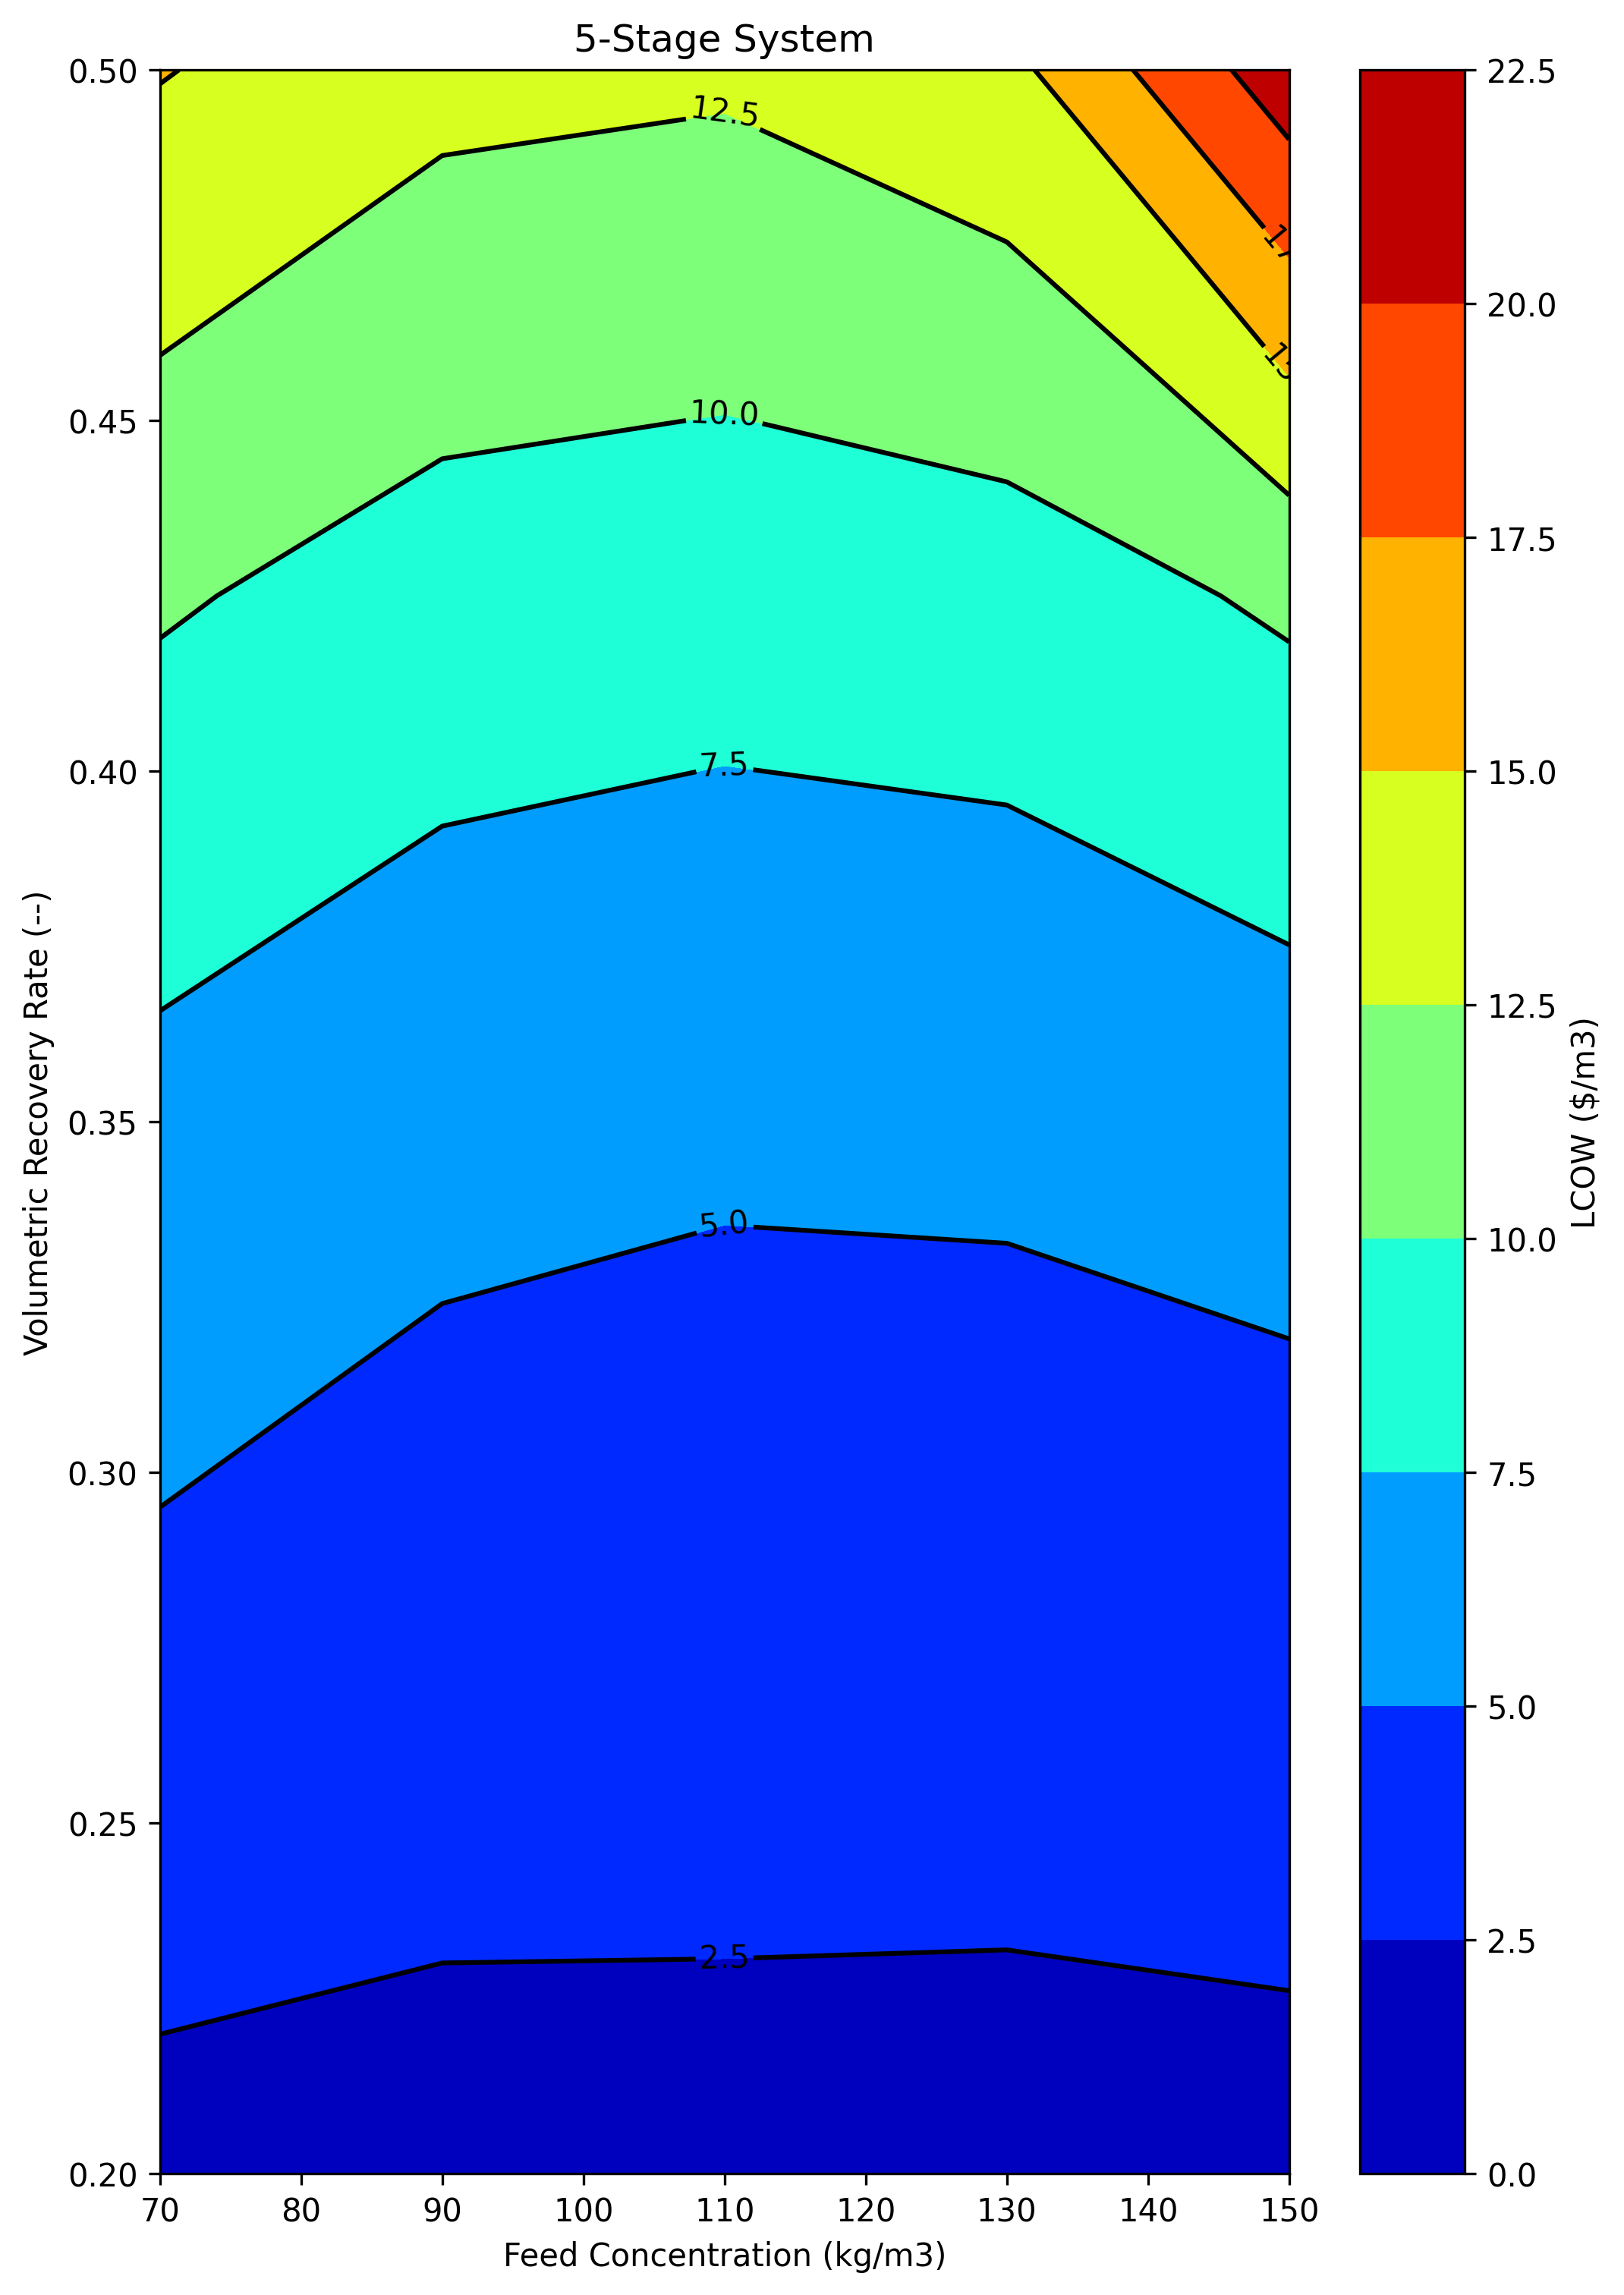

In [31]:
results5, _, fig5, ax5 = feed_concentration_recovery_profile(m=None,number_of_stages=5, points_per_sweep=5)